In [ ]:
### Train / Validation : Early stop : Plot Losses / Precision / F1 / Accuracy ::: BEST MODEL

import os
import torch
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import numpy as np

# Custom dataset class
class ArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(self.labels['labels'].apply(lambda x: x.split(', ')))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.labels.iloc[idx, 1].split(', ')
        labels = self.mlb.transform([labels])[0]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels, dtype=torch.float32)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = ArtDataset(csv_file='dataset/labelsalgomix.csv', root_dir='dataset/train', transform=transform)

# Split dataset into training and validation
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model
model = resnet50(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, len(full_dataset.mlb.classes_))

# Training
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds == labels).float().sum()
    return correct / labels.numel()

early_stopping_patience = 3
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        running_train_acc += calculate_accuracy(outputs, labels).item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            running_val_acc += calculate_accuracy(outputs, labels).item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = running_val_acc / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Acc: {epoch_train_acc}, Val Loss: {epoch_val_loss}, Val Acc: {epoch_val_acc}')

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_art_model_algomix.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('best_art_model_algomix.pth'))

# Plot loss graph
plt.figure()
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, marker='o', label='Training Loss')
plt.plot(epochs_range, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot accuracy graph
plt.figure()
plt.plot(epochs_range, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate model
def evaluate_model(loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# Get predictions and true labels for validation set
val_labels, val_preds = evaluate_model(val_loader)

# Convert lists to arrays
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')

# Display results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Fold 1/5


/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.7042646408081055, Train Acc: 0.5094696879386902, Val Loss: 0.4191831350326538, Val Acc: 0.8674242496490479
Epoch 2, Train Loss: 0.36001041531562805, Train Acc: 0.9375, Val Loss: 0.35328346490859985, Val Acc: 0.875
Epoch 3, Train Loss: 0.19201605021953583, Train Acc: 0.9460227489471436, Val Loss: 0.36014533042907715, Val Acc: 0.8787878751754761
Epoch 4, Train Loss: 0.08805251866579056, Train Acc: 0.9876893758773804, Val Loss: 0.3493191599845886, Val Acc: 0.8636363744735718
Epoch 5, Train Loss: 0.04542984440922737, Train Acc: 0.998106062412262, Val Loss: 0.29416972398757935, Val Acc: 0.8901515007019043
Epoch 6, Train Loss: 0.027039168402552605, Train Acc: 0.998106062412262, Val Loss: 0.33307433128356934, Val Acc: 0.8636363744735718
Epoch 7, Train Loss: 0.01743180863559246, Train Acc: 0.9990530014038086, Val Loss: 0.32934677600860596, Val Acc: 0.8712121248245239
Epoch 8, Train Loss: 0.012249243445694447, Train Acc: 1.0, Val Loss: 0.3978692889213562, Val Acc: 0.88257

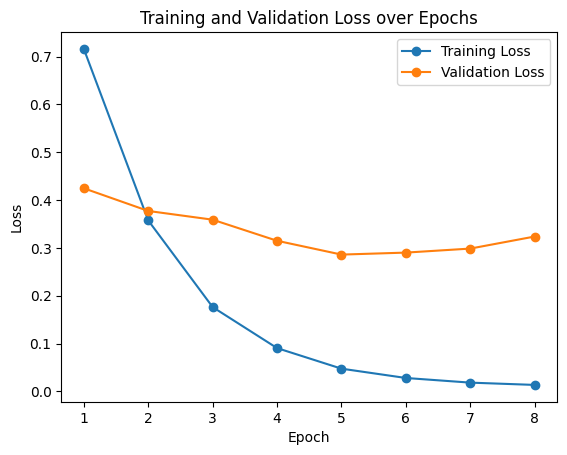

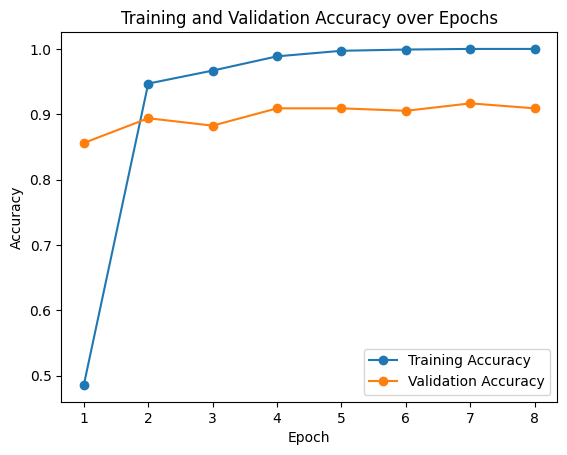

Precision: 0.1250
Recall: 0.0417
F1 Score: 0.0625


/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cyriancr/.pyenv/versions/3.10.8/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

In [4]:
import os
import torch
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from torchvision.models import resnet50
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Custom dataset class
class ArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(self.labels['labels'].apply(lambda x: x.split(', ')))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        labels = self.labels.iloc[idx, 1].split(', ')
        labels = self.mlb.transform([labels])[0]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(labels, dtype=torch.float32)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load full dataset
full_dataset = ArtDataset(csv_file='dataset/labelsalgomix.csv', root_dir='dataset/train', transform=transform)

# Model and training settings
num_epochs = 10
early_stopping_patience = 3
k_folds = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    preds = torch.sigmoid(outputs) > 0.5
    correct = (preds == labels).float().sum()
    return correct / labels.numel()

# Prepare cross-validation
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold = 0

# Track metrics
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []

for train_indices, val_indices in kf.split(full_dataset):
    print(f'Fold {fold+1}/{k_folds}')

    # Prepare data loaders for this fold
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize model, criterion, and optimizer
    model = resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len(full_dataset.mlb.classes_))
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        running_train_acc = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            running_train_acc += calculate_accuracy(outputs, labels).item()

        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_acc = running_train_acc / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        running_val_acc = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                running_val_acc += calculate_accuracy(outputs, labels).item()

        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = running_val_acc / len(val_loader)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_train_loss}, Train Acc: {epoch_train_acc}, Val Loss: {epoch_val_loss}, Val Acc: {epoch_val_acc}')

        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), f'best_art_model_fold_{fold}.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)
    fold += 1

# Calculate average metrics across all folds
avg_train_loss = np.mean([np.mean(losses) for losses in fold_train_losses])
avg_val_loss = np.mean([np.mean(losses) for losses in fold_val_losses])
avg_train_acc = np.mean([np.mean(accs) for accs in fold_train_accuracies])
avg_val_acc = np.mean([np.mean(accs) for accs in fold_val_accuracies])

print(f'Average Train Loss: {avg_train_loss}')
print(f'Average Val Loss: {avg_val_loss}')
print(f'Average Train Accuracy: {avg_train_acc}')
print(f'Average Val Accuracy: {avg_val_acc}')

# Plot loss graph for the last fold
plt.figure()
epochs_range = range(1, len(fold_train_losses[-1]) + 1)
plt.plot(epochs_range, fold_train_losses[-1], marker='o', label='Training Loss')
plt.plot(epochs_range, fold_val_losses[-1], marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# Plot accuracy graph for the last fold
plt.figure()
plt.plot(epochs_range, fold_train_accuracies[-1], marker='o', label='Training Accuracy')
plt.plot(epochs_range, fold_val_accuracies[-1], marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

# Function to evaluate model
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds

# Load the best model from the last fold for evaluation
model.load_state_dict(torch.load(f'best_art_model_fold_{fold-1}.pth'))

# Get predictions and true labels for validation set
val_labels, val_preds = evaluate_model(val_loader, model)

# Convert lists to arrays
val_labels = np.array(val_labels)
val_preds = np.array(val_preds)

# Calculate precision, recall, and F1 score
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')

# Display results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [8]:
### RUN ART MODEL

import clip
import torch
from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from torchvision import transforms

# Load the fine-tuned model
model.load_state_dict(torch.load('best_art_model_fold_4.pth'))
model.eval()

# Load CLIP model and preprocess
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device)

# Define the same transform used for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


# Load your CSV file
df = pd.read_csv('dataset/labelsalgomix.csv')

# Initialize an empty dictionary to hold your keyword-to-algorithm mappings
keyword_to_algo = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    labels = [label.strip().lower() for label in row['labels'].split(", ")]
    algorithm = labels[0]  # Assuming the first label is always the algorithm

    # Map each label to the algorithm
    for label in labels:
        keyword_to_algo[label] = algorithm


# Function to predict and verify descriptions
def predict_and_verify(image_path, model, clip_model, clip_processor, mlb, keyword_to_algo):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    
    # Preprocess the image for the classification model
    input_image = transform(image).unsqueeze(0).to(device)
    
    # Predict keywords
    with torch.no_grad():
        output = model(input_image)
        probs = torch.sigmoid(output).cpu().numpy()[0]
        top_indices = probs.argsort()[-5:][::-1]  # Top 5 keywords
        keywords = [mlb.classes_[idx] for idx in top_indices]
    
    # Preprocess the image for CLIP
    clip_image_input = clip_processor(image).unsqueeze(0).to(device)
    
    # Encode image and generated keywords with CLIP
    text_inputs = torch.cat([clip.tokenize(keyword) for keyword in keywords]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(clip_image_input)
        text_features = clip_model.encode_text(text_inputs)
    
    # Compute similarities
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarities = (image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]
    
    # Refine and return top keywords
    refined_keywords = sorted(zip(keywords, similarities), key=lambda x: x[1], reverse=True)[:5]
    top_keywords = [kw[0] for kw in refined_keywords]
    
    # Map keywords to algorithms
    algorithm_count = {}
    for keyword in top_keywords:
        keyword_lower = keyword.lower()
        algorithm = keyword_to_algo.get(keyword_lower, None)
        if algorithm:
            if algorithm in algorithm_count:
                algorithm_count[algorithm] += 1
            else:
                algorithm_count[algorithm] = 1

    # Choose the algorithm that appears most frequently
    if algorithm_count:
        final_algorithm = max(algorithm_count, key=algorithm_count.get)
    else:
        final_algorithm = None

    return top_keywords, final_algorithm

# Example usage
image_path = "image33.png"
keywords, algorithm = predict_and_verify(image_path, model, clip_model, clip_preprocess, full_dataset.mlb, keyword_to_algo)

print("Predicted Keywords:", keywords)
print("Mapped Algorithm:", algorithm)


Predicted Keywords: ['Perlin noise', 'swirls', 'reaction diffusion', 'motion', 'flow']
Mapped Algorithm: perlin noise
